# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import gc  # Garbage collector
import glob
import io
import os

import pandas as pd
import soundfile as sf
from tqdm import tqdm  # Progress bar library

SEED = 137
DATASET_DIR = "../datasets/uzbek-speech-corpus/data"
SAMPLED_AUDIO_DIR = os.path.join(DATASET_DIR, "sampled_audio")
ALL_DATA_PATH = os.path.join(DATASET_DIR, "dataset.csv")
SAMPLED_DATA_PATH = os.path.join(DATASET_DIR, "sampled.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")

### Create csv file with all data and computed statistics

In [2]:
# from pathlib import Path
import re


def extract_speaker_id(text: str) -> str:
    # Get the first part before the first underscore
    first_part = text.split("_")[0]

    # If it's purely numeric (e.g., "857628019"), return it
    if first_part.isdigit():
        return first_part

    # If it's text enumerated (e.g., "yer1", "yer12"),
    # Use regex to extract the alpha part.
    match = re.match(r"([a-zA-Z]+)", first_part)
    if match:
        return match.group(1)

    return first_part


def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "speaker_id": [],
        "path": [],
        "text_original": [],
        "duration": [],
        "char_count": [],
        "word_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        # Extract metadata
        stats["speaker_id"].append(extract_speaker_id(df.iloc[i]["id"]))
        stats["path"].append(df.iloc[i]["audio"]["path"])

        text = df.iloc[i]["sentence"]
        stats["text_original"].append(text)

        # Decode audio
        audio_bytes = df.iloc[i]["audio"]["bytes"]
        audio_array, sr = sf.read(io.BytesIO(audio_bytes))

        duration = len(audio_array) / sr
        stats["duration"].append(duration)
        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))
        if not ignore_sampling_rate:
            stats["sampling_rate"].append(sr)

        # Clear audio from memory immediately
        del audio_bytes, audio_array

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")


def get_set_type_from_parquet_file(parquet_file_path):
    parquet_file_name = Path(parquet_file_path).name.lower()
    if parquet_file_name.startswith("train"):
        return "train"
    elif parquet_file_name.startswith("validation"):
        return "validation"
    elif parquet_file_name.startswith("test"):
        return "test"
    else:
        return "unknown"


all_data = []
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)

    stats = compute_statistics(df_partial)
    stats_df = pd.DataFrame(stats)

    stats_df["type"] = get_set_type_from_parquet_file(parquet_file_path)
    all_data.append(stats_df)

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

# Combine all data
all_data_df: pd.DataFrame = pd.concat(all_data, ignore_index=True)
del all_data  # Free memory
gc.collect()

all_data_df.to_csv(ALL_DATA_PATH, index_label="id")

Found 29 parquet files. Started processing...



Processing files: 100%|██████████| 29/29 [00:39<00:00,  1.35s/it]


In [2]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

print(all_data_df.info())
print(all_data_df.describe())
print("\nFirst few rows:")
all_data_df

<class 'pandas.core.frame.DataFrame'>
Index: 108387 entries, 0 to 108386
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   speaker_id     108387 non-null  object 
 1   path           108387 non-null  object 
 2   text_original  108387 non-null  object 
 3   duration       108387 non-null  float64
 4   char_count     108387 non-null  int64  
 5   word_count     108387 non-null  int64  
 6   type           108387 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.6+ MB
None
            duration     char_count     word_count
count  108387.000000  108387.000000  108387.000000
mean        3.484478      41.399928       5.707022
std         1.831397      23.001803       2.868702
min         0.150000       3.000000       1.000000
25%         2.186500      25.000000       4.000000
50%         3.060000      36.000000       5.000000
75%         4.302500      52.000000       7.000000
max        34.4

,speaker_id,path,text_original,duration,char_count,word_count,type
id,,,,,,,
0,352830655,352830655_1_79926_1.wav,biroz hayajondaman chunki videoaloqa orqali o'...,4.4000,66,7,train
1,352830655,352830655_1_79927_1.wav,shuningdek bishkekda koronavirus sabab,3.0000,38,4,train
2,352830655,352830655_1_79928_1.wav,qozog'istonda sevishgan juftlik to'ylarini,3.2400,42,4,train
3,352830655,352830655_1_79929_1.wav,bu haqda ria,1.0000,12,3,train
4,352830655,352830655_1_79930_1.wav,eslatib o'tamiz aqsh koronavirusga chalinganla...,3.8400,52,6,train
...,...,...,...,...,...,...,...
108382,1218456233,1218456233_1_3026_2.wav,og'iz juftladiyu lekin indamadi,3.0575,31,4,train
108383,1218456233,1218456233_1_3027_3.wav,lekin shu ahmoq bilan aytishib nima obro' top...,4.6385,71,11,train
108384,1218456233,1218456233_1_3029_3.wav,yerda yotgan panshaxasini yelkasiga tashlab yu...,3.9000,55,7,train


### Dataset statistics plotted

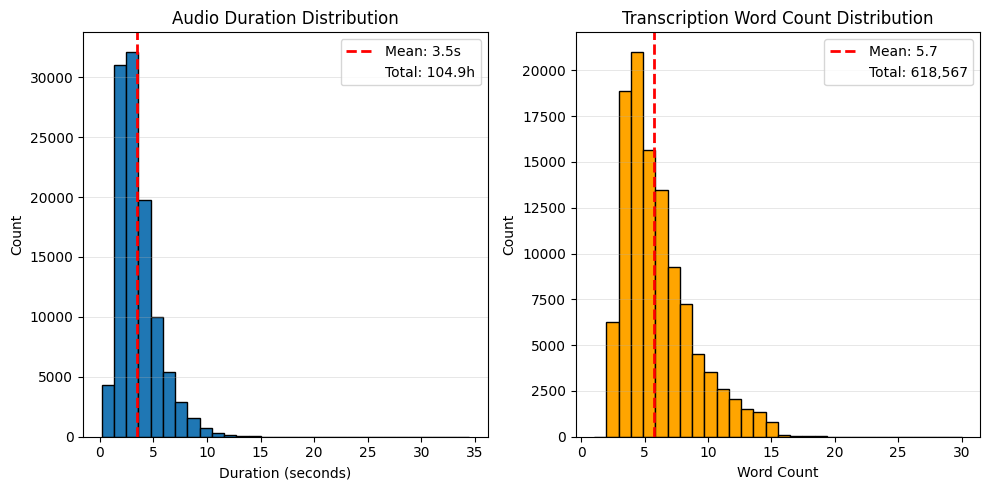


Total duration per set type:
type
train         96.411059
test           4.496491
validation     4.001369
Name: duration, dtype: float64

Total Unique Speakers: 842


speaker_id
1459541555    4897
1187023182    3928
qiyomat       3315
802338886     3089
jamila        3005
              ... 
822182508        1
521222920        1
484551065        1
523178386        1
1214766770       1
Name: count, Length: 842, dtype: int64

In [3]:
from scripts.dataset_plotting import plot_distribution_graphs

plot_distribution_graphs(all_data_df)
print(f"\nTotal duration per set type:")
print((all_data_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False))

# Count recordings per speaker
speaker_counts = all_data_df["speaker_id"].value_counts()
print(f"\nTotal Unique Speakers: {len(speaker_counts):,.0f}")
speaker_counts

### Extract longer recordings

short_recordings: 
count          3000
unique          582
top       153988527
freq             18
Name: speaker_id, dtype: object

medium_recordings: 
count         11353
unique          489
top       911079671
freq            200
Name: speaker_id, dtype: object

long_recordings: 
count           3038
unique           237
top       1187023182
freq             250
Name: speaker_id, dtype: object

Total duration per set type:
type
train         27.129491
validation     1.660486
test           1.545316
Name: duration, dtype: float64


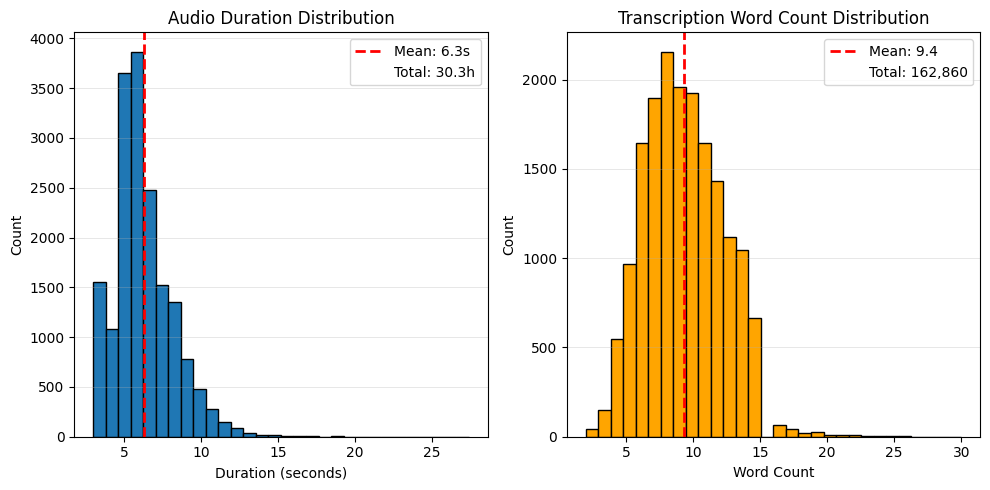

,speaker_id,path,text_original,duration,char_count,word_count,type
id,,,,,,,
20,352830655,352830655_1_79951_1.wav,butun mahalla faollari uchastka nozirlari andi...,5.0400,63,7,train
33,352830655,352830655_1_79964_1.wav,toshkent shahar hokimi lavozimiga qayta tasdiq...,5.3600,61,7,train
96,352830655,352830655_1_80046_1.wav,o'zbekiston sanitariya epidemiologik osoyishta...,6.1600,67,6,train
104,352830655,352830655_1_86203_1.wav,reuters manila filippinaviahalokatda qizi bila...,5.2400,70,8,train
120,352830655,352830655_1_86228_1.wav,ekipaj toshkent aeroporti hududiga kirganida,3.6000,44,5,train
...,...,...,...,...,...,...,...
108261,1218456233,1218456233_1_2857_2.wav,aytishgan bilan aytishib so'kishgan bilan so'k...,5.4305,76,9,train
108262,1218456233,1218456233_1_2858_2.wav,uning ovuldagi kelinlar bilan yumdalashgan vaq...,5.0945,65,8,train
108285,1218456233,1218456233_1_2894_2.wav,nazarimda oyim uni bir so'zligini bilar edi,3.9000,43,7,train


In [6]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")

short_audios = (all_data_df["duration"] >= 3) & (all_data_df["duration"] < 5)
medium_audios = (all_data_df["duration"] >= 5) & (all_data_df["duration"] < 8)
long_audios = (all_data_df["duration"] >= 8) & (all_data_df["duration"] < 30)

short_samples = (
    all_data_df[short_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 30)), include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(3000, weights=all_data_df["duration"], random_state=SEED)
print(f"short_recordings: \n{short_samples["speaker_id"].describe()}")

medium_samples = (
    all_data_df[medium_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 200)), include_groups=False)  # Maximum up to 200 recordings per speaker
    .reset_index(level=0)
)
print(f"\nmedium_recordings: \n{medium_samples["speaker_id"].describe()}")

long_samples = (
    all_data_df[long_audios]
    .groupby("speaker_id")
    .apply(lambda x: x.sample(min(len(x), 250)), include_groups=False)  # Maximum up to 250 recordings per speaker
    .reset_index(level=0)
)
print(f"\nlong_recordings: \n{long_samples["speaker_id"].describe()}")

sampled_df = pd.concat([short_samples, medium_samples, long_samples]).sort_index()
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(f"\nTotal duration per set type:")
print((sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False))

plot_distribution_graphs(sampled_df)

sampled_df

### Extract audios from parquet files to manually check the quality of the overall dataset

In [7]:
import scripts.audio_preprocessing as ap

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

# Extract sampled audios from nested directories
sampled_paths = set(sampled_df["path"].tolist())
print(f"Need to extract {len(sampled_paths)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(sampled_paths):
        break

    df_partial = pd.read_parquet(parquet_file_path)
    df_partial["path"] = df_partial["id"].astype(str) + ".wav"
    df_partial.set_index("path", inplace=True)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial.index.isin(sampled_paths)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["audio"]["bytes"]

        output_filename = row["audio"]["path"]
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_filename)

        waveform, stat = ap.process_audio_bytes(
            output_filename,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=1.3
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 17391 audio files
Found 29 parquet files. Started processing...



Processing files: 100%|██████████| 29/29 [04:26<00:00,  9.20s/it]


Extracted and normalized 17391 audio files to ../datasets/uzbek-speech-corpus/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,352830655_1_79951_1.wav,-20.1350,-23.1249,5.0400,5.0400,0.0,0.4041,False
1,352830655_1_79964_1.wav,-20.3566,-23.1582,5.3600,5.3600,0.0,0.4183,False
2,352830655_1_80046_1.wav,-27.8750,-23.1407,6.1600,6.1600,0.0,0.4411,False
3,352830655_1_86203_1.wav,-23.1426,-23.1352,5.2400,5.2400,0.0,0.4166,False
4,352830655_1_86228_1.wav,-33.9467,-23.2575,3.6000,3.6000,0.0,0.6448,False
...,...,...,...,...,...,...,...,...
17386,1218456233_1_2857_2.wav,-30.8694,-23.1986,5.4305,5.4305,0.0,0.6014,False
17387,1218456233_1_2858_2.wav,-30.2568,-23.1980,5.0945,5.0945,0.0,0.6942,False
17388,1218456233_1_2894_2.wav,-30.8940,-23.2149,3.9000,3.9000,0.0,0.5785,False
17389,1218456233_1_2896_4.wav,-25.7753,-23.1521,5.0945,5.0945,0.0,0.5009,False


In [8]:
processed_audio_stats_df.describe()

,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,17391.000000,17391.000000,17391.000000,17391.000000,17391.000000,17391.000000
mean,-26.560483,-23.167866,6.279516,6.189078,0.090438,0.507494
std,6.420286,0.078787,1.915830,1.898201,0.416614,0.105725
min,-57.731000,-26.936500,3.000000,0.500000,0.000000,0.170900
25%,-30.835500,-23.196900,5.180000,5.100000,0.000000,0.435100
50%,-26.197600,-23.154700,5.906500,5.840000,0.000000,0.498200
75%,-21.875800,-23.121500,7.226500,7.166500,0.000000,0.571100
max,-7.052400,-23.046900,27.386500,27.386500,11.650000,0.950000


In [9]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)

old_total_duration = sampled_df["duration"].sum() / 3600
old_duration_mean = sampled_df["duration"].mean()

# --- Replace sampled_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled_df = sampled_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled_df["duration"] = (
    sampled_df["final_duration"].combine_first(sampled_df["duration"])
)

# Drop helper columns
sampled_df = sampled_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_to_remove)
]

# Remove these recordings entirely
sampled_df = sampled_df[
    ~sampled_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_df

60 recordings are removed from the sample
Before audio preprocessing: total duration - 30.335 h | mean 6.3 s
After audio preprocessing: total duration - 29.858 h (reduced 26 min) | mean 6.2 s


,speaker_id,path,text_original,duration,char_count,word_count,type,input_audio_filename
0,352830655,352830655_1_79951_1.wav,butun mahalla faollari uchastka nozirlari andi...,5.0400,63,7,train,352830655_1_79951_1.wav
1,352830655,352830655_1_79964_1.wav,toshkent shahar hokimi lavozimiga qayta tasdiq...,5.3600,61,7,train,352830655_1_79964_1.wav
2,352830655,352830655_1_80046_1.wav,o'zbekiston sanitariya epidemiologik osoyishta...,6.1600,67,6,train,352830655_1_80046_1.wav
3,352830655,352830655_1_86203_1.wav,reuters manila filippinaviahalokatda qizi bila...,5.2400,70,8,train,352830655_1_86203_1.wav
4,352830655,352830655_1_86228_1.wav,ekipaj toshkent aeroporti hududiga kirganida,3.6000,44,5,train,352830655_1_86228_1.wav
...,...,...,...,...,...,...,...,...
17386,1218456233,1218456233_1_2857_2.wav,aytishgan bilan aytishib so'kishgan bilan so'k...,5.4305,76,9,train,1218456233_1_2857_2.wav
17387,1218456233,1218456233_1_2858_2.wav,uning ovuldagi kelinlar bilan yumdalashgan vaq...,5.0945,65,8,train,1218456233_1_2858_2.wav
17388,1218456233,1218456233_1_2894_2.wav,nazarimda oyim uni bir so'zligini bilar edi,3.9000,43,7,train,1218456233_1_2894_2.wav
17389,1218456233,1218456233_1_2896_4.wav,kelajakda uni ikki xonadonning boshini qovusht...,5.0945,58,7,train,1218456233_1_2896_4.wav


In [15]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
from pathlib import Path
from scripts import google_transcribe

# Prepare audio paths
# sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
audio_paths = sampled_df["path"].apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)).tolist()

# Process files in parallel using two regions
print(f"Processing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription...\n")

try:
    results = google_transcribe.transcribe_batch_parallel(
        audio_paths=audio_paths,
        regions=["eu", "us"],
        max_workers=12
    )
except Exception as err:
    print(f"\nCritical error during parallel processing: {type(err).__name__}: {err}")
    raise

# Process results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in results:
    transcription_entry = {
        "path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save results
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
print(f"\nSaved transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled_df) * 100:.2f}%")

predicted_transcripts_df

Processing 9491 audio files using 2 regions (eu, us)...
Starting parallel transcription...



Transcribing: 100%|██████████| 9491/9491 [32:09<00:00,  4.92file/s]  


Saved transcription results to: ../datasets/uzbek-speech-corpus/data/google_spt_transcriptions.csv

Transcription Complete!
✓ Successfully transcribed: 9491
✗ Failed: 0
Success rate: 100.00%


,path,predicted_sentence,error_message,error_type
0,352830655_1_87605_1.wav,videoselektor yig'ilishda suvdan tejab,None,None
1,352830655_1_80046_1.wav,O'zbekiston sanitariya epidemiologik osoyishta...,None,None
2,352830655_1_87620_1.wav,Rossiya hukumati raisi Mixail Mishustin uzoq,None,None
3,352830655_1_87000_1.wav,qanday o'tgan haqida materiallar tayyorlandi.,None,None
4,352830655_1_87599_1.wav,Yig'ilishda paxta-to'qimachilik klasterlari sa...,None,None
...,...,...,...,...
9486,1218456233_1_2830_2.wav,Daraksiz ketgan bolalarni go'yo ko'rmoqchi bo'...,None,None
9487,1218456233_1_2840_2.wav,To'yi munosabati bilan o'tkazilgan poygada jam...,None,None
9488,1218456233_1_2918_3.wav,Yoki ko'chadan kirib kelayotganida xuddi yosh ...,None,None
9489,1218456233_1_2858_2.wav,Uning ovuldagi kelinlar bilan yundalashgan vaq...,None,None


In [42]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled_df = sampled_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)
sampled_df

<class 'pandas.core.frame.DataFrame'>
Index: 17331 entries, 0 to 9939
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                17331 non-null  object 
 1   predicted_sentence  17297 non-null  object 
 2   error_message       0 non-null      float64
 3   error_type          0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 677.0+ KB
None


,speaker_id,path,duration,word_count,type,text_original,predicted_sentence,error_message,error_type
0,352830655,352830655_1_79951_1.wav,5.0400,7,train,butun mahalla faollari uchastka nozirlari andi...,butun mahalla faollari uchastka nozirlari Andi...,NaN,NaN
1,352830655,352830655_1_79964_1.wav,5.3600,7,train,toshkent shahar hokimi lavozimiga qayta tasdiq...,Toshkent shahar hokimi lavozimiga qayta tasdiq...,NaN,NaN
2,352830655,352830655_1_80046_1.wav,6.1600,6,train,o'zbekiston sanitariya epidemiologik osoyishta...,O'zbekiston sanitariya epidemiologik osoyishta...,NaN,NaN
3,352830655,352830655_1_86203_1.wav,5.2400,8,train,reuters manila filippinaviahalokatda qizi bila...,"Reuters (Manila, Filippin) via halokatda qizi ...",NaN,NaN
4,352830655,352830655_1_86228_1.wav,3.6000,5,train,ekipaj toshkent aeroporti hududiga kirganida,Ekipaj Toshkent aeroporti hududiga kirganiga,NaN,NaN
...,...,...,...,...,...,...,...,...,...
17326,1218456233,1218456233_1_2857_2.wav,5.4305,9,train,aytishgan bilan aytishib so'kishgan bilan so'k...,"Aytishgan bilan aytishib, so'kishgan bilan so'...",NaN,NaN
17327,1218456233,1218456233_1_2858_2.wav,5.0945,8,train,uning ovuldagi kelinlar bilan yumdalashgan vaq...,Uning ovuldagi kelinlar bilan yundalashgan vaq...,NaN,NaN
17328,1218456233,1218456233_1_2894_2.wav,3.9000,7,train,nazarimda oyim uni bir so'zligini bilar edi,Nazarimda oyim uni bir so'zligini bilar edi.,NaN,NaN
17329,1218456233,1218456233_1_2896_4.wav,5.0945,7,train,kelajakda uni ikki xonadonning boshini qovusht...,Kelajakda uni ikki xonadonning boshini qovusht...,NaN,NaN


In [43]:
import scripts.similarity_metrics as similarity_metrics

sampled_df.drop(columns=["error_message", "error_type", "input_audio_filename", "char_count"], inplace=True,
                errors="ignore")
sampled_df.rename(columns={"predicted_sentence": "text_spt"}, inplace=True)

# Reorder text_original column to be one before the last column
cols = list(sampled_df.columns)
cols.remove("text_original")
cols.insert(-1, "text_original")
sampled_df = sampled_df[cols]

# Apply similarity metrics to each row
metrics = sampled_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_original"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled_df = pd.concat([sampled_df, metrics_df], axis=1)

sampled_df.sort_values("wer", ascending=False)

,speaker_id,path,duration,word_count,type,text_original,text_spt,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
618,413998257,413998257_1_13084_2.wav,6.3865,3,train,ajragan ajriqqa zor,"Rajgan, Raj, Raj, Raj, Raj, Raj, Raj, Raj, Raj...",ajragan ajriqqa zor,rajgan raj raj raj raj raj raj raj raj raj raj...,170.3333,107.0526,0.0039,3,511
11995,qiyomat,qiyomat4.3_data_qiyomat4.3-1.wav,18.6400,7,train,lekin dilim juda osuda va farahli edi,Biron ko'rgazma ochilgan bo'lsa ko'raman dedim...,lekin dilim juda osuda va farahli edi,biron ko'rgazma ochilgan bo'lsa ko'raman dedim...,4.0000,5.4595,0.1377,7,34
16258,oxirgizamon,oxirgizamon3_data_oxirgizamon3-91.wav,14.5200,8,train,bu safar ham biror durustroq manzarani suratga...,"U esa oʻz ustida oʻzi kulib, ""Men starosferach...",bu safar ham biror durustroq manzarani suratga...,u esa o'z ustida o'zi kulib men starosferachim...,2.7500,2.9412,0.0238,8,30
10939,1245300168,1245300168_1_8665_2.wav,5.3065,3,train,oyog'imda oyoq qolmadi,Avval qoramoy hidi anqib turgan temir yo'ldan ...,oyog'imda oyoq qolmadi,avval qoramoy hidi anqib turgan temir yo'ldan ...,2.6667,1.8636,0.1892,3,8
1708,646732078,646732078_1_59990_1.wav,16.0400,5,train,ketmonni yelkasiga tashlagancha etik kiyib,Ketmonni yelkasiga tashlagancha etik kiyib g'o...,ketmonni yelkasiga tashlagancha etik kiyib,ketmonni yelkasiga tashlagancha etik kiyib g'o...,2.4000,2.3810,0.4565,5,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12522,733860783,733860783_1_1904_2.wav,7.2865,9,train,bu ayyor yigitni urib yuborishini ham indamasl...,"Bu ayyor yigitni urib yuborishini ham, indamas...",bu ayyor yigitni urib yuborishini ham indamasl...,bu ayyor yigitni urib yuborishini ham indamasl...,0.0000,0.0000,1.0000,9,9
12519,733860783,733860783_1_1887_2.wav,6.9265,8,train,muqaddam anjomlarini yig'ishtirib bo'lguncha u...,"Muqaddam anjomlarini yig'ishtirib bo'lguncha, ...",muqaddam anjomlarini yig'ishtirib bo'lguncha u...,muqaddam anjomlarini yig'ishtirib bo'lguncha u...,0.0000,0.0000,1.0000,8,8
12518,733860783,733860783_1_1884_2.wav,5.7265,9,train,alimardon uning har bir harakatini diqqat bila...,Alimardon uning har bir harakatini diqqat bila...,alimardon uning har bir harakatini diqqat bila...,alimardon uning har bir harakatini diqqat bila...,0.0000,0.0000,1.0000,9,9
12517,733860783,733860783_1_1883_2.wav,5.9065,5,train,ignani chiqarib sterilizator qopqog'iga tashladi,Ignani chiqarib sterilizator qopqog'iga tashladi.,ignani chiqarib sterilizator qopqog'iga tashladi,ignani chiqarib sterilizator qopqog'iga tashladi,0.0000,0.0000,1.0000,5,5


In [49]:
aligned_mask = sampled_df["wer"] == 0.0

total_recordings = len(sampled_df)
not_aligned_duration = sampled_df[~aligned_mask]["duration"].sum() / 3600

len_aligned_recordings = len(sampled_df[aligned_mask])
aligned_duration = sampled_df[aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

print("\nFinal sample after removing mis-aligned recordings:")

# Remove poor alignment (wer > 0%)
sampled_df = sampled_df[aligned_mask]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
print((sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False))
sampled_df.describe()

Total duration of the sample: 29.86 hours
Audio and transcription aligned recordings: 6,113 - 10.01 hours
Remaining recordings: 11,218 - 19.85 hours

Final sample after removing mis-aligned recordings:
type
train         8.832264
validation    0.638683
test          0.542384
Name: duration, dtype: float64


,duration,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,6113.000000,6113.000000,6113.0,6113.0,6113.0,6113.000000,6113.000000
mean,5.896940,8.852936,0.0,0.0,1.0,8.852936,8.852936
std,1.743984,2.944757,0.0,0.0,0.0,2.944757,2.944757
min,3.000000,2.000000,0.0,0.0,1.0,2.000000,2.000000
25%,5.006500,7.000000,0.0,0.0,1.0,7.000000,7.000000
50%,5.606500,9.000000,0.0,0.0,1.0,9.000000,9.000000
75%,6.780000,11.000000,0.0,0.0,1.0,11.000000,11.000000
max,15.118500,24.000000,0.0,0.0,1.0,24.000000,24.000000


In [50]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 15,200 audio files


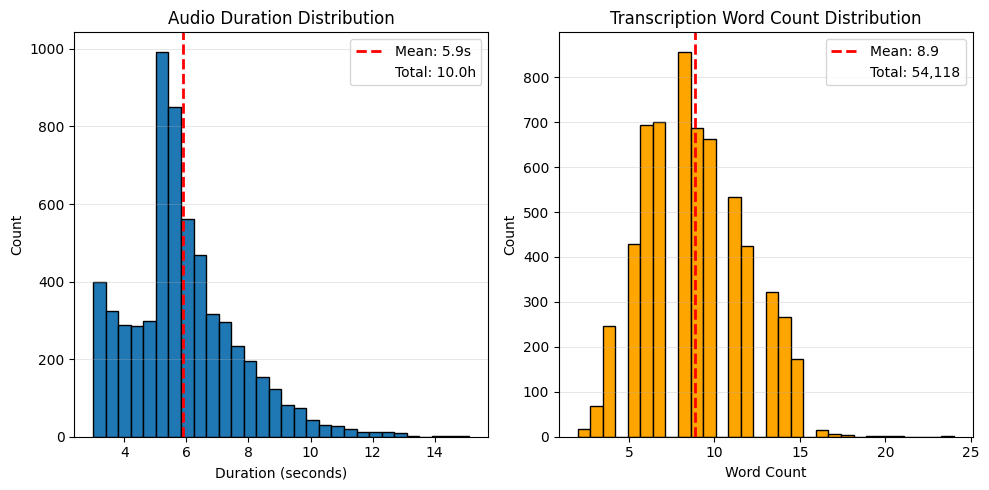

type
train         8.832264
validation    0.638683
test          0.542384
Name: duration, dtype: float64

In [63]:
from scripts.dataset_plotting import plot_distribution_graphs

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

plot_distribution_graphs(sampled_df)
duration_by_type = sampled_df.groupby("type")["duration"].sum() / 3600
duration_by_type.sort_values(ascending=False)

In [64]:
# Check if speakers in test or validation set repeated in train set
# Only leave recordings with truly unique speakers (that has not repeated in train set)
train_speakers = set(sampled_df.query("type == 'train'")["speaker_id"].unique())
val_speakers = set(sampled_df.query("type == 'validation'")["speaker_id"].unique())
test_speakers = set(sampled_df.query("type == 'test'")["speaker_id"].unique())

# Identify speakers present in both sets
print(f"Overlap Train/Val: {len(train_speakers.intersection(val_speakers))}")
print(f"Overlap Train/Test: {len(train_speakers.intersection(test_speakers))}")
print(f"Overlap Val/Test: {len(val_speakers.intersection(test_speakers))}")

# Reassign overlapping speakers from 'test' to 'train' to ensure a strict split
is_test = sampled_df["type"] == "test"
is_overlapping = sampled_df["speaker_id"].isin(test_speakers.intersection(train_speakers))
sampled_df.loc[is_test & is_overlapping, "type"] = "train"

# Reassign overlapping speakers from 'validation' to 'train' to ensure a strict split
is_validation = sampled_df["type"] == "validation"
is_overlapping = sampled_df["speaker_id"].isin(val_speakers.intersection(train_speakers))
sampled_df.loc[is_validation & is_overlapping, "type"] = "train"

(sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Overlap Train/Val: 7
Overlap Train/Test: 11
Overlap Val/Test: 0


type
train         9.312054
validation    0.372106
test          0.329172
Name: duration, dtype: float64

In [65]:
# Add more data for test and validation to compensate
additional_speakers = (sampled_df.query("type == 'train'")["speaker_id"]
                       .sort_values()
                       .sample(20, random_state=SEED)
                       .tolist())
additional_speakers_mask = sampled_df["speaker_id"].isin(additional_speakers)

test_speakers = additional_speakers[:10]
val_speakers = additional_speakers[10:]

sampled_df.loc[sampled_df["speaker_id"].isin(test_speakers), "type"] = "test"
sampled_df.loc[sampled_df["speaker_id"].isin(val_speakers), "type"] = "validation"

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
# Verify the new duration totals
(sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

type
train         7.760116
test          1.149161
validation    1.104054
Name: duration, dtype: float64

In [66]:
train_speakers = set(sampled_df[sampled_df["type"] == "train"]["speaker_id"])
val_speakers = set(sampled_df[sampled_df["type"] == "validation"]["speaker_id"])
test_speakers = set(sampled_df[sampled_df["type"] == "test"]["speaker_id"])

print(f"Overlap Train/Val: {train_speakers.intersection(val_speakers)}")
print(f"Overlap Train/Test: {train_speakers.intersection(test_speakers)}")
print(f"Overlap Val/Test: {val_speakers.intersection(test_speakers)}")

Overlap Train/Val: set()
Overlap Train/Test: set()
Overlap Val/Test: set()
